In [1]:
from jax import config
config.update("jax_enable_x64", True)

import matplotlib.pyplot as plt
import jax.numpy as np
from scipy.optimize import root
from jax import jacrev
from jax.experimental.ode import odeint

In [2]:
%matplotlib ipympl

In [3]:
# Known parameters (from example or literature)
Ks = 1.0          # g/liter (fixed)
Feed = 0.05        # Feed flowrate [liters/hour], assumed constant for simplicity
V0 = 1.0          # Initial volume [liters]
S0 = 10.0         # Initial substrate concentration [g/liter]
X0, P0 = 0.05, 0.0   # Initial cell and product concentrations


# Explicit ODE system
def fed_batch(y, t, mu_max, Yxs, Ypx):
    X, P, S, V = y
    
    rg = mu_max * S / (1.0 + S)
    rp = Ypx * rg
    
    dXdt = - Feed * (X / V) + rg * X
    dPdt = - Feed * (P / V) + rp * X
    dSdt =   Feed  * (S0 - S)/V - rg * (X / Yxs)
    dVdt =   Feed
    
    return np.array([dXdt, dPdt, dSdt, dVdt])

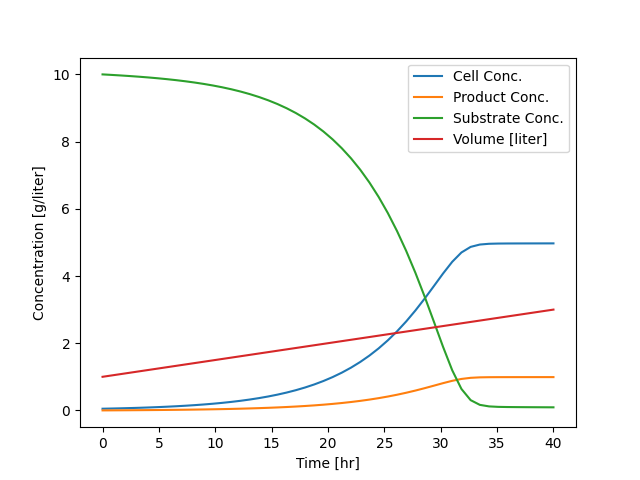

In [4]:

initial_conditions = [X0, P0, S0, V0]

# Nominal parameters.
mu_max = 0.20      # 1/hour
Yxs = 0.5          # g/g
Ypx = 0.2          # g/g

# Timespan.
t = np.linspace(0,40)

# Solution.
sol = odeint(fed_batch, initial_conditions, t, mu_max, Yxs, Ypx)
X,P,S,V = sol

# Checking if it makes sense.
plt.plot(t,X)
plt.plot(t,P)
plt.plot(t,S)
plt.plot(t,V)

plt.xlabel('Time [hr]')
plt.ylabel('Concentration [g/liter]')
plt.legend(['Cell Conc.',
            'Product Conc.',
            'Substrate Conc.',
            'Volume [liter]'])
plt.show()

In [5]:
del sol, X,P,S,V,t, initial_conditions, mu_max, Ypx, Yxs

In [6]:
# Define the Fed-batch bioreactor model implicitly
def F(i1,i2,i3, o1,o2,o3):
    # Uncertain parameters
    mu_max, Yxs, Ypx = i1, i2, i3
    
    # Given outputs (desired states)
    X_target, P_target, Sf_target = o1, o2, o3

    # Solve ODE with given parameters
    y0 = np.array([X0, P0, S0, V0])
    t = np.linspace(0, 10, 100)  # 10-hour integration
    sol = odeint(fed_batch, y0, t, mu_max, Yxs, Ypx)
    
    X_final, P_final, S_final, V_final = sol[-1]

    # Implicit equations to match target outputs
    LHS1 = X_target - X_final
    LHS2 = P_target - P_final
    LHS3 = Sf_target - S_final

    return np.array([LHS1,
                     LHS2,
                     LHS3])



# Jacobians with JAX
dFdi1 = jacrev(F, 0)
dFdi2 = jacrev(F, 1)
dFdi3 = jacrev(F, 2)
dFdo1 = jacrev(F, 3)
dFdo2 = jacrev(F, 4)
dFdo3 = jacrev(F, 5)

In [7]:
# Implicit function derivative for 3D (di/do)
def fprime(i1, i2, i3, o1, o2, o3):
    dFdo = np.array([dFdo1(i1, i2, i3, o1, o2, o3),
                     dFdo2(i1, i2, i3, o1, o2, o3),
                     dFdo3(i1, i2, i3, o1, o2, o3)]).squeeze().T

    dFdi = np.array([dFdi1(i1, i2, i3, o1, o2, o3),
                     dFdi2(i1, i2, i3, o1, o2, o3),
                     dFdi3(i1, i2, i3, o1, o2, o3)]).squeeze().T

    di_do = -dFdo @ np.linalg.pinv(dFdi)
    return di_do

In [8]:
# Ellipsoid center (desired nominal conditions)
X_target, P_target, S_target = 2.0, 1.0, 3.0  # example nominal points

# Define ellipsoid parameters (uncertainty ranges)
a_X, b_P, c_S = 0.4, 0.3, 0.2  # uncertainty ranges for each output

# Generate a parameterized 3D ellipsoid around the nominal outputs
phi = np.linspace(0, 2 * np.pi, 30)
theta = np.linspace(0, np.pi, 20)
phi, theta = np.meshgrid(phi, theta)

# Ellipsoid surface for outputs
pX = X_target + a_X * np.sin(theta) * np.cos(phi)
pY = P_target + b_P * np.sin(theta) * np.sin(phi)
pZ = S_target + c_S * np.cos(theta)

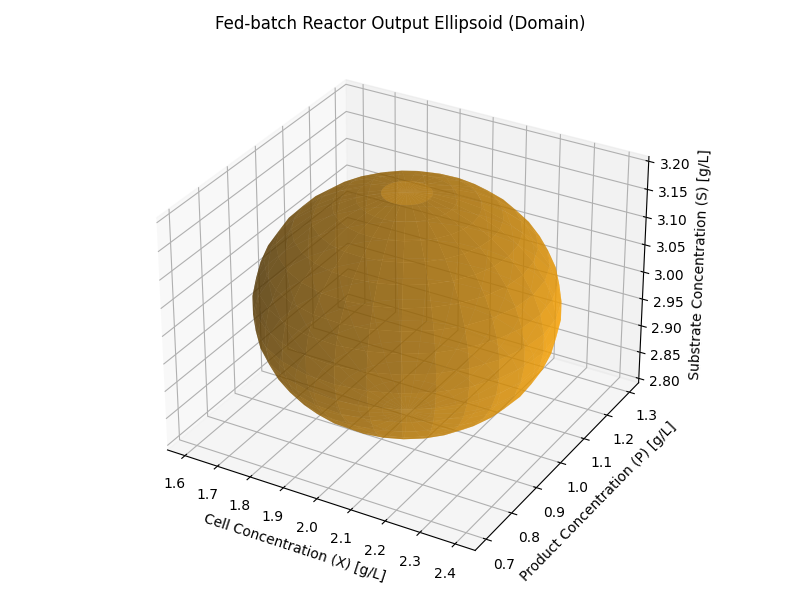

In [9]:
# Immediately visualize the defined ellipsoid for clarity
fig0 = plt.figure(figsize=(8, 6))
ax0 = fig0.add_subplot(111, projection='3d')
ax0.plot_surface(pX, pY, pZ, color='orange', alpha=0.6)
ax0.set_title('Fed-batch Reactor Output Ellipsoid (Domain)')
ax0.set_xlabel('Cell Concentration (X) [g/L]')
ax0.set_ylabel('Product Concentration (P) [g/L]')
ax0.set_zlabel('Substrate Concentration (S) [g/L]')
plt.tight_layout()
plt.show()

In [10]:
# Prepare path and step differences for continuation
path = np.vstack((pX.flatten(), pY.flatten(), pZ.flatten())).T
dpath = path[1:] - path[:-1]

In [11]:
# Initial solution
sol = root(lambda X, o: F(X[0], X[1], X[2], *o), [1.0, 1.0, 1.0], args=(path[0],))
# sol = root(lambda X, o: F(X, o), [1.0, 1.0, 1.0], args=(path[0],))
i1, i2, i3 = sol.x
o1, o2, o3 = path[0]

inp, out = [[i1, i2, i3]], [[o1, o2, o3]]

print(sol)

 message: The solution converged.
 success: True
  status: 1
     fun: [-6.883e-14 -2.556e-13  5.729e-14]
       x: [ 4.621e-01  2.892e-01  5.085e-01]
  method: hybr
    nfev: 65
    fjac: [[-2.717e-01 -1.390e-01  9.523e-01]
           [-8.312e-01 -4.648e-01 -3.050e-01]
           [-4.850e-01  8.745e-01 -1.075e-02]]
       r: [ 5.501e+01 -1.805e+01  2.494e-01  7.424e+00  9.014e-01
           -1.697e+00]
     qtf: [-5.462e-11 -8.398e-11  9.980e-11]


In [12]:
# Continuation integration loop (RK4)
for h in dpath:
    do1, do2, do3 = h

    k1 = fprime(i1, i2, i3, o1, o2, o3) @ h
    k2 = fprime(*(np.array([i1, i2, i3]) + k1 / 2), *(np.array([o1, o2, o3]) + h / 2)) @ h
    k3 = fprime(*(np.array([i1, i2, i3]) + k2 / 2), *(np.array([o1, o2, o3]) + h / 2)) @ h
    k4 = fprime(*(np.array([i1, i2, i3]) + k3), *(np.array([o1, o2, o3]) + h)) @ h

    di = (k1 + 2*k2 + 2*k3 + k4) / 6

    i1, i2, i3 = np.array([i1, i2, i3]) + di
    o1, o2, o3 = np.array([o1, o2, o3]) + h

    if not np.all(np.abs(F(i1, i2, i3, o1, o2, o3)) < 1e-2):
        sol = root(lambda X, o: F(X[0], X[1], X[2], *o), [i1, i2, i3], args=([o1, o2, o3],))
        if sol.success:
            i1, i2, i3 = sol.x
        else:
            print("Correction failed at", o1, o2, o3)

    inp.append([i1, i2, i3])
    out.append([o1, o2, o3])

inp, out = np.array(inp), np.array(out)

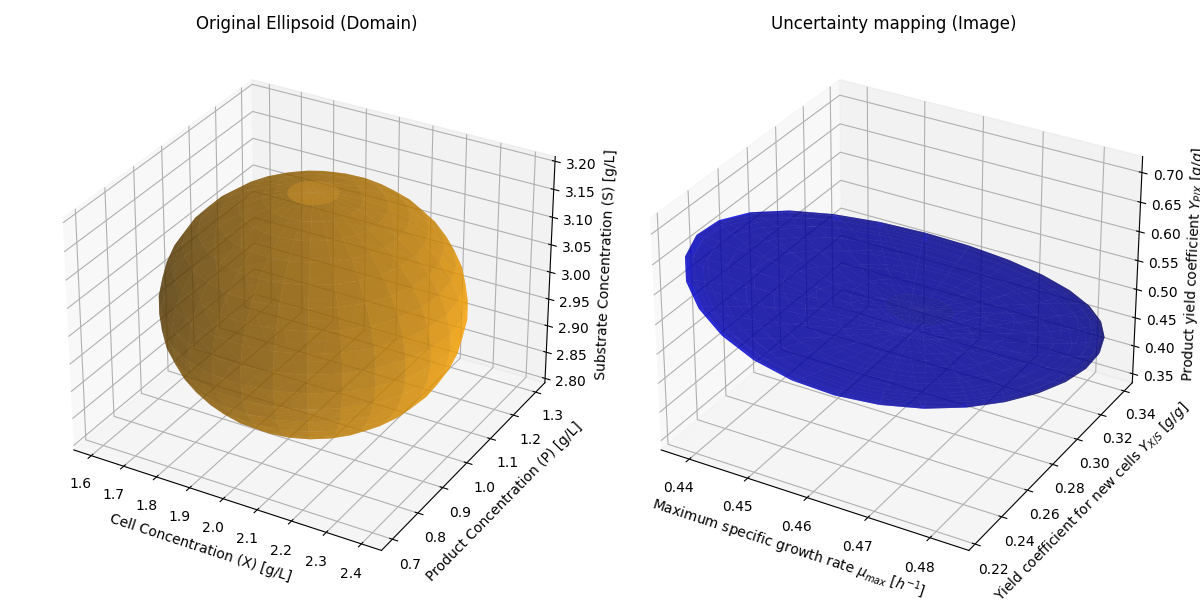

In [13]:
# Visualization of both original and mapped ellipsoid surfaces
X_mapped = inp[:, 0].reshape(theta.shape)
Y_mapped = inp[:, 1].reshape(theta.shape)
Z_mapped = inp[:, 2].reshape(theta.shape)

fig1 = plt.figure(figsize=(12, 6))
ax1 = fig1.add_subplot(121, projection='3d')
ax1.plot_surface(pX, pY, pZ, color='orange', alpha=0.6)
ax1.set_title('Original Ellipsoid (Domain)')
ax1.set_xlabel('Cell Concentration (X) [g/L]')
ax1.set_ylabel('Product Concentration (P) [g/L]')
ax1.set_zlabel('Substrate Concentration (S) [g/L]')
plt.tight_layout()
ax2 = fig1.add_subplot(122, projection='3d')
ax2.plot_surface(X_mapped, Y_mapped, Z_mapped, color='blue', alpha=0.6)
ax2.set_title('Uncertainty mapping (Image)')
ax2.set_xlabel('Maximum specific growth rate $\mu_{max}$ $[h^{-1}]$')
ax2.set_ylabel('Yield coefficient for new cells $Y_{X/S}$ $[g/g]$')
ax2.set_zlabel('Product yield coefficient $Y_{P/X}$ $[g/g]$')
plt.tight_layout()
plt.show()

In [14]:
mu_max, Yxs, Ypx = inp[:,0], inp[:, 1], inp[:, 2]

scenarios = np.c_[mu_max, Yxs, Ypx]

In [19]:
solutions = []
initial_conditions = [X0, P0, S0, V0]
for i, (_mu_max, _Yxs, _Ypx) in enumerate(scenarios):
    t = np.linspace(0,10)
    sol_ivp = odeint(fed_batch, initial_conditions, t, _mu_max, _Yxs, _Ypx)
    X_final = sol_ivp[0][-1]
    P_final = sol_ivp[1][-1]
    S_final = sol_ivp[2][-1]
    this_solution =  [X_final, P_final, S_final]
    solutions += [this_solution]

    print(f'{i}, ({_mu_max:1.2f}, {_Yxs:1.2f}, {_Ypx:1.2f}), {solutions[i]}')

0, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
1, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
2, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
3, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
4, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
5, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
6, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
7, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
8, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64), Array(3.2, dtype=float64)]
9, (0.46, 0.29, 0.51), [Array(2., dtype=float64), Array(1., dtype=float64

In [20]:
print(np.array(solutions).shape)

(600, 3)


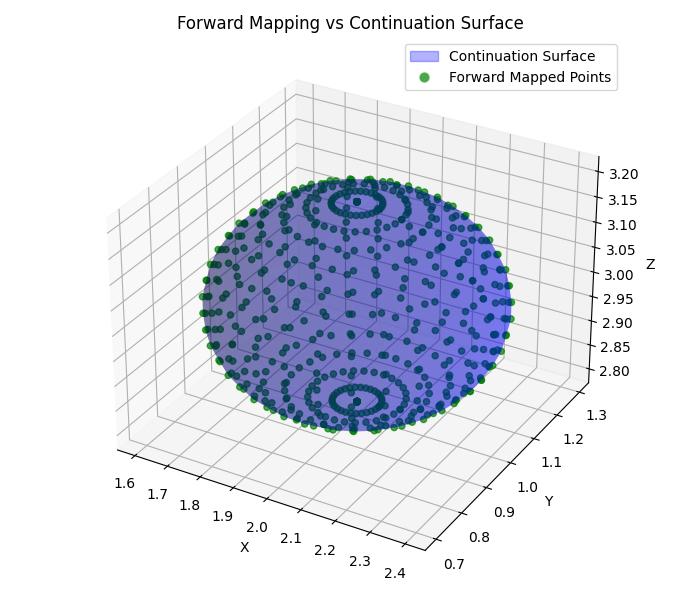

In [30]:
# Forward mapping plotting

# Run forward mapping with inverse mapping inputs
forward_mapped = np.array(solutions)

# Comparison plot
from matplotlib.patches import Patch
from matplotlib.lines import Line2D

fig2 = plt.figure(figsize=(7,6))
ax3 = fig2.add_subplot(111, projection='3d')
ax3.plot_surface(pX, pY, pZ, color='blue', alpha=0.3)
ax3.scatter(forward_mapped[:,0], forward_mapped[:,1], forward_mapped[:,2], color='green', alpha=0.7)

legend_elements = [
    Patch(facecolor='blue', edgecolor='blue', alpha=0.3, label='Continuation Surface'),
    Line2D([0], [0], marker='o', color='w', label='Forward Mapped Points',
           markerfacecolor='green', markersize=8, alpha=0.7)
]

ax3.legend(handles=legend_elements)
ax3.set_title('Forward Mapping vs Continuation Surface')
ax3.set_xlabel('X'); ax3.set_ylabel('Y'); ax3.set_zlabel('Z')
plt.tight_layout()
plt.show()

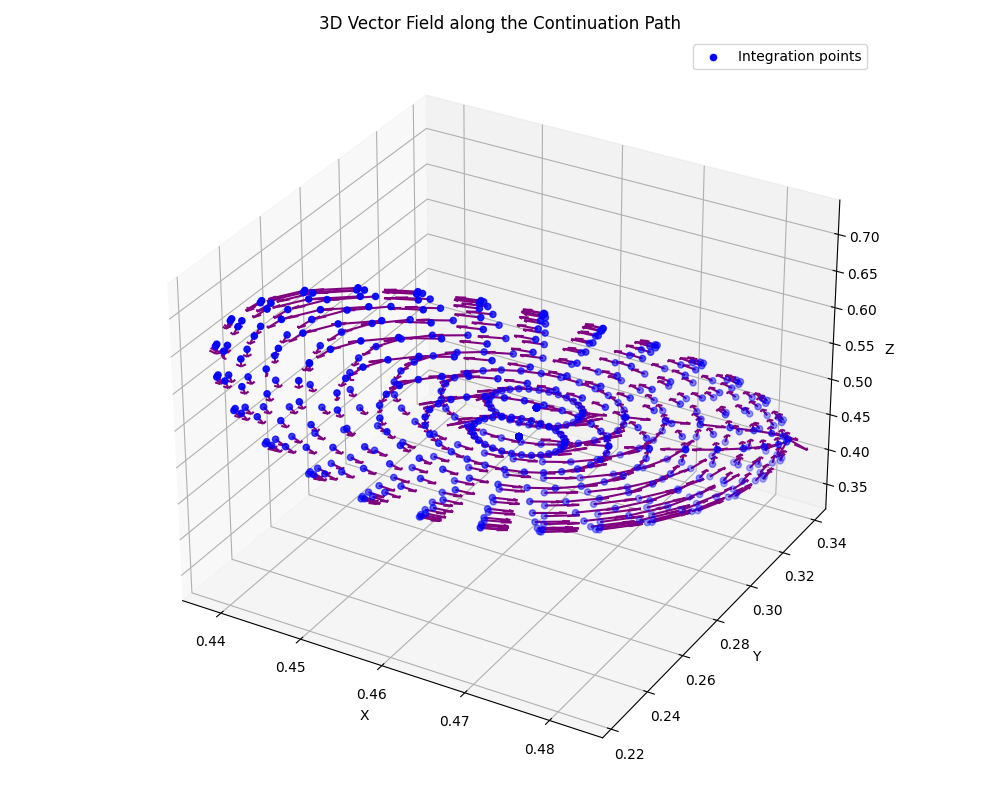

In [31]:

inp, out = inp.T, out.T

# Define a similar "fprime_trans" function adapted clearly for 3D
def fprime_trans_3d(y_current, y_next, inp_current):
    Jac = fprime(*inp_current, *y_current)
    return Jac @ (y_next - y_current)

# Computing estimated vector fields
dx_est_conc = np.zeros_like(inp)

for k in range(out.shape[1] - 1):
    dx = fprime_trans_3d(out[:, k], out[:, k + 1], inp[:, k])
    dx_est_conc = dx_est_conc.at[:, k].set(dx)

# 3D Quiver plot clearly visualizing vector fields
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

ax.quiver(inp[0, :-1], inp[1, :-1], inp[2, :-1],
          dx_est_conc[0, :-1], dx_est_conc[1, :-1], dx_est_conc[2, :-1],
          length=0.01, normalize=True, color='purple')

# clearly plotting the integration points (path)
ax.scatter(inp[0], inp[1], inp[2], color='blue', s=20, label='Integration points')

# Setting labels and titles clearly
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Vector Field along the Continuation Path')
ax.legend()

plt.tight_layout()
plt.show()

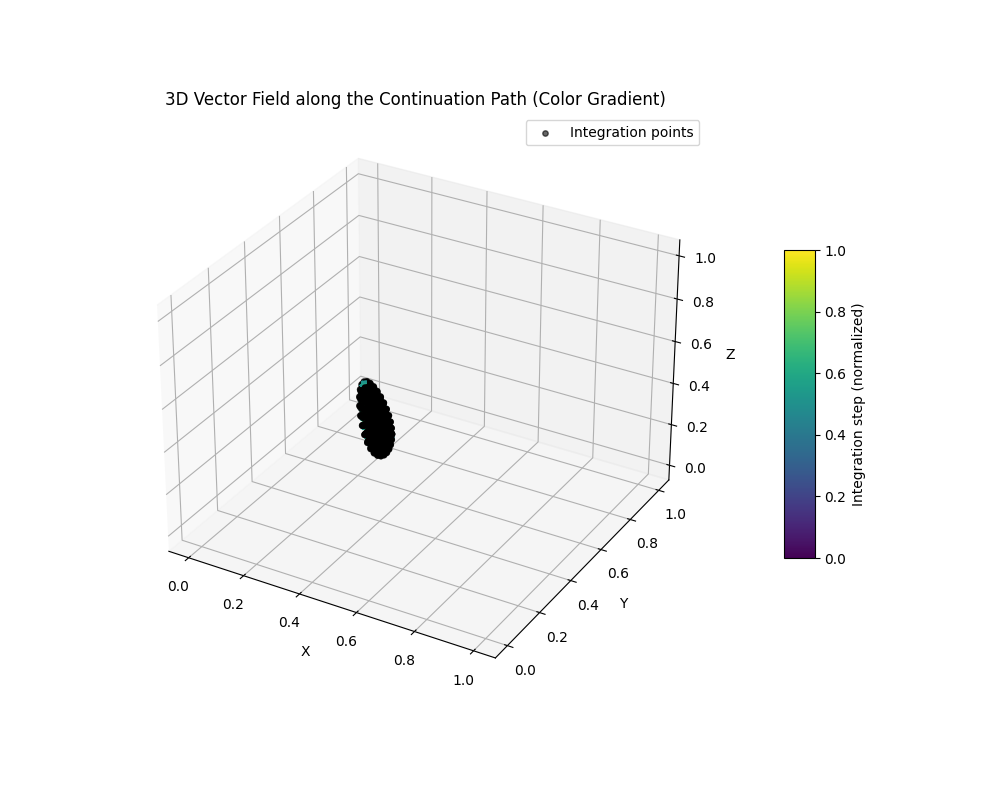

In [32]:
import matplotlib.cm as cm

# Create a colormap gradient based on arrow sequence
num_arrows = inp.shape[1] - 1
colors = cm.viridis(np.linspace(0, 1, num_arrows))

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot arrows individually to allow color gradient
for k in range(num_arrows):
    ax.quiver(
        inp[0, k], inp[1, k], inp[2, k],
        dx_est_conc[0, k], dx_est_conc[1, k], dx_est_conc[2, k],
        length=0.02, normalize=True, color=colors[k]
    )

# Add integration points for clarity
ax.scatter(inp[0], inp[1], inp[2], color='black', s=15, alpha=0.6, label='Integration points')
# plt.tight_layout()

# Titles and labels
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Vector Field along the Continuation Path (Color Gradient)')

# Add a colorbar as a visual aid
mappable = cm.ScalarMappable(cmap='viridis')
mappable.set_array(np.linspace(0, 1, num_arrows))
cbar = plt.colorbar(mappable, ax=ax, shrink=0.5, aspect=10, pad=0.1)
cbar.set_label('Integration step (normalized)')

ax.legend()
# plt.tight_layout()
plt.show()